# Deep Hidden Physics Model 

### Example-2 

## Duffing oscillator 

$\normalsize{Governing \ Equation}$ 

$ \large{\frac{d^2x}{dt^2} + \delta \frac{dx}{dt} + \alpha x + \beta x^3 = \gamma cos(\omega t)}; \ \normalsize{for \ t \in [0,T]} $

$\delta$  $\rightarrow$ controls the amount of damping,   
$\alpha$ $\rightarrow$ controls the linear stiffness,   
$\beta$ $\rightarrow$ controls the amount of non-linearity in the restoring force,  
$\gamma$ $\rightarrow$ amplitude of the periodic driving force  
$\omega$ $\rightarrow$ the angular frequency of driving force.

The equation of motion can be written in terms of displacement $(x)$ and velocity $(v)$ as,

$ \large{\frac{dx}{dt} = v}; \\ \large{\frac{dv}{dt} = - \delta v - \alpha x - \beta x^3 + \gamma cos(\omega t)}; $

We consider the governing equation of system is partially known, Our objective is to identify the remaining terms in equation using ${Deep \ Hidden \ Physics \ Model}$. 
We approximate the solution $(x, v)$ by a neural network and the remaining unknown terms in equation by a second neural network $\mathcal{N}$.

We can rewrite equations in the form,

$ \large{\frac{dx}{dt} = v}; \\ \large{\frac{dv}{dt} = \mathcal{N}(t,x,v) + \gamma cos(\omega t)}; $

## Importing Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [2]:
import torchphysics as tp
import numpy as np
import torch
import pytorch_lightning as pl
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import sys
from torchphysics.problem.conditions.condition import  DataCondition, HPM_EquationLoss_at_Sampler

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

RANDOM_SEED = 2308
np.random.seed(RANDOM_SEED)

__Python VERSION: 3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]
__pyTorch VERSION: 1.13.1
__CUDA VERSION
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


## Data Generation

### Defining equations to solver

In [4]:
def equation_of_motion(s, t, delta, alpha, beta, gamma, Omega):

    x, v = s # position, velocity
        
    ds_dt = [v, -delta*v - alpha*x - beta*x**3 + gamma*np.cos(Omega*t)] # governing equations

    return ds_dt

In [5]:
# ---- control parameters -----

delta = 0.3
Omega = 1.2
alpha = -1.0
beta  = 1.0
gamma = 0.2

# ---- initial condition ----

s_initial = [1.0, 0.] # [x initial, v initial]

# ------ solver -------

t_final = 10*np.pi/Omega # simulation time
dt =  0.01 # time step for solver
t =  np.arange(0.0,t_final + dt,dt) 

In [6]:
soln = odeint(equation_of_motion,s_initial,t, args=(delta, alpha, beta, gamma, Omega))        

In [7]:
x_soln = soln[:,0]
v_soln = soln[:,1]

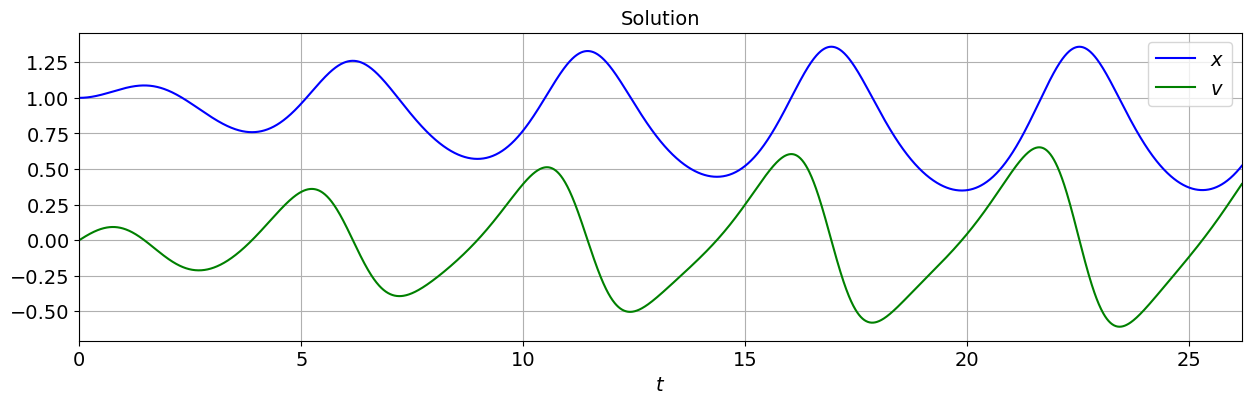

In [8]:
plt.figure(figsize=(15,4))
plt.plot(t, x_soln, 'b', label='$x$')
plt.plot(t, v_soln, 'g', label='$v$')
plt.xlim(t.min(),t.max())
plt.legend(fontsize=14)
plt.xlabel('$t$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Solution',fontsize=14)
plt.grid('True')
plt.show()

### Training data 

In [9]:
t_tensor = torch.tensor(t,dtype=torch.float32).reshape(-1,1)
x_tensor = torch.tensor(x_soln,dtype=torch.float32).reshape(-1,1)
v_tensor = torch.tensor(v_soln,dtype=torch.float32).reshape(-1,1)

data_tensor = torch.cat((t_tensor,x_tensor, v_tensor),axis=1) # Reference values for t , x, v


In [10]:
# ------  Training data  -----------

train_points = 100 # no of training data points
coll_points = 1000 # no of collocation points to constrain ODE/PDE residual 

In [11]:
idx = np.random.choice(len(t), train_points, replace=False)
data_train_tensor = data_tensor[idx]

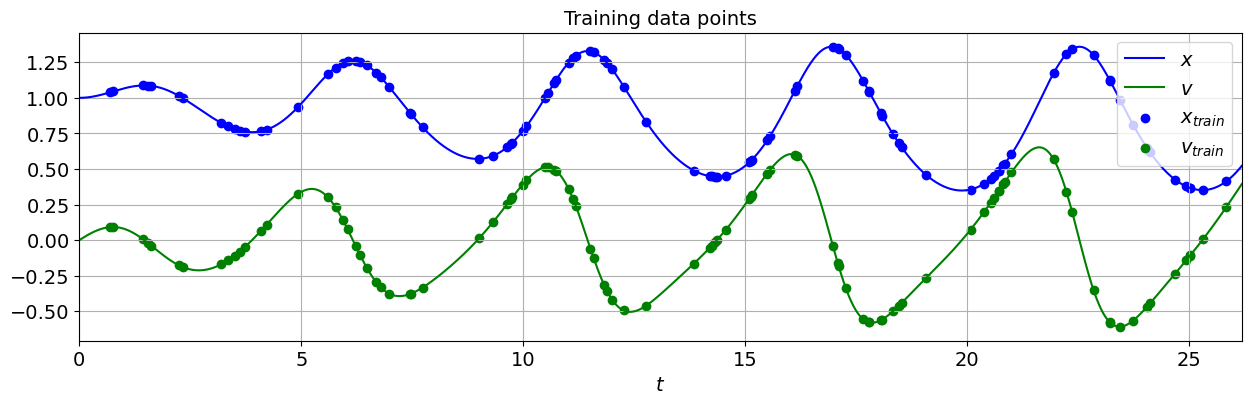

In [12]:
plt.figure(figsize=(15,4))
plt.plot(t, x_soln, 'b', label='$x$')
plt.plot(t, v_soln, 'g', label='$v$')
plt.scatter(data_train_tensor[:,0],data_train_tensor[:,1],c='b',label='$x_{train}$')
plt.scatter(data_train_tensor[:,0],data_train_tensor[:,2],c='g',label='$v_{train}$')
plt.xlim(t.min(),t.max())
plt.legend(fontsize=14)
plt.xlabel('$t$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Training data points',fontsize=14)
plt.grid('True')
plt.show()

### Defining input-output spaces 

In [13]:
T = tp.spaces.R1('t') # input space (t)
X = tp.spaces.R1('x') # x space
V = tp.spaces.R1('v') # v space
S =  tp.spaces.R2('s')# output space (x,v)
N_phy = tp.spaces.R1('N') # hidden physics output space

In [14]:
# --------- neural net solution -----------
input_space_sol = T
output_space_sol = S
# ---------- neural net hidden physics ---------
input_space_hid_phy = T*X*V # input to hidden network are (t, x, v)
output_space_hid_phy = N_phy


### Sampling collocation points 

In [15]:
T_domain = tp.domains.Interval(space = T, lower_bound=t.min(), upper_bound=t.max())

In [16]:
domain_sampler = tp.samplers.RandomUniformSampler(T_domain, n_points=coll_points)
#plot  = tp.utils.scatter(T, domain_sampler)

### neural net solution 

In [17]:
normalization_layer = tp.models.NormalizationLayer(T_domain)
fcn_layer_sol = tp.models.FCN(input_space=input_space_sol,output_space=output_space_sol, hidden = (64,64,64))
model_sol = tp.models.Sequential(normalization_layer, fcn_layer_sol)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### data condition 

In [19]:
input_train = tp.spaces.Points(torch.column_stack([data_train_tensor[:,0:1]]),input_space_sol)
output_train = tp.spaces.Points(torch.column_stack([data_train_tensor[:,1:3]]),output_space_sol)

In [20]:
batch_size_data = len(input_train)

data_loader = tp.utils.PointsDataLoader((input_train, output_train), batch_size = batch_size_data,shuffle  = False, pin_memory = True)

data_condition = DataCondition(module=model_sol,
                               dataloader=data_loader, 
                               norm=2,
                               use_full_dataset=False, 
                               name="Data_Condition",
                               weight = 1)
                                                        

### neural net hidden physics 

In [21]:
fcn_layer_hid_phy = tp.models.FCN(input_space=input_space_hid_phy,output_space=output_space_hid_phy,hidden = (128,128))
model_hidden_phy = tp.models.Sequential(fcn_layer_hid_phy)

In [22]:
def hiddenPhysics(t,s):
    
    x, v = s[:,0:1], s[:,1:2]
    input_model_hid = tp.spaces.Points(torch.column_stack((t,x,v)), input_space_hid_phy) 
    output_model_hid = model_hidden_phy(input_model_hid)
    
    return output_model_hid.as_tensor


def residual_equation(t):
    
    s = model_sol(tp.spaces.Points(t, T))
    s = s.as_tensor 
    output_hid_phy = hiddenPhysics(t,s)
    x = s[:,0:1]
    v = s[:,1:2]
    grad_x_t = tp.utils.grad(x, t) 
    grad_v_t = tp.utils.grad(v, t) 
    residual_x =  grad_x_t - v
    residual_v = grad_v_t - output_hid_phy - gamma*torch.cos(Omega*t) 

    return torch.column_stack((residual_x,residual_v))



### hidden physics condition 

In [23]:
hidden_phy_condition =  HPM_EquationLoss_at_Sampler(module=model_hidden_phy,
                                           sampler=domain_sampler,
                                           residual_fn= residual_equation)

### Training model

In [24]:
training_conditions = [data_condition,hidden_phy_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

In [ ]:
epochs = 10000
trainer = pl.Trainer(gpus=1, max_steps=epochs, logger=True,benchmark=True)
trainer.fit(solver)

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 25.7 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)


/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 0:  90%|████████▉ | 8958/10001 [01:22<00:09, 107.96it/s, loss=0.0015, v_num=3]  

In [ ]:
def output_hidden_physics(t):
    
    s = model_sol(tp.spaces.Points(t, T))
    s = s.as_tensor 
    output_hid_phy = hiddenPhysics(t,s)
    
    return output_hid_phy

In [ ]:
def output_solution(t):
    
    s = model_sol(tp.spaces.Points(t, T))
    s = s.as_tensor 
    x = s[:,0:1]
    v = s[:,1:2]
    
    return x, v

### Predictions 

In [ ]:
hidden_phy_pred = output_hidden_physics(t_tensor)
x_pred, v_pred  = output_solution(t_tensor)

In [ ]:
hidden_phy_pred = hidden_phy_pred.detach().numpy()
x_pred = x_pred.detach().numpy()
v_pred = v_pred.detach().numpy()

In [ ]:
def L2_ERROR(true_val,pred_val):
    
    return np.linalg.norm(true_val-pred_val,2)/np.linalg.norm(true_val,2)


In [ ]:
l2_error_x = L2_ERROR(x_soln.flatten(),x_pred.flatten())
l2_error_v = L2_ERROR(v_soln.flatten(),v_pred.flatten())

In [ ]:
print('L2 error x : ',l2_error_x)
print('L2 error v : ',l2_error_v)

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(t,x_soln.flatten(),label='$x: True$')
plt.plot(t,x_pred.flatten(),label='$x: Pred$')
plt.xlim(t.min(),t.max())
plt.legend(fontsize=14)
plt.xlabel('$t$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Position Prediction',fontsize=14)
plt.grid('True')
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(t,v_soln.flatten(),label='$v: True$')
plt.plot(t,v_pred.flatten(),label='$v: Pred$')
plt.xlim(t.min(),t.max())
plt.legend(fontsize=14)
plt.xlabel('$t$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Velocity Prediction',fontsize=14)
plt.grid('True')
plt.show()

In [ ]:
actual_phy =  -delta*v_soln - alpha*x_soln - beta*x_soln**3

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(t,actual_phy.flatten(),label='$\mathcal{N}: True$')
plt.plot(t,hidden_phy_pred.flatten(),label='$\mathcal{N}: Pred$')
plt.xlim(t.min(),t.max())
plt.legend(fontsize=14)
plt.xlabel('$t$',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Hidden Physics Prediction',fontsize=14)
plt.grid('True')
plt.show()

$\large{ \mathcal{N}(t,x,v) \approx \ - \delta v - \alpha x - \beta x^3 }$